# 計算の入出力ファイルの取得

外部計算機を用いた場合の計算の入出力ファイルは
普通の作り方をすると、local PCに移動している。
を取得の仕方を示す。


```sh
verdi calcjob inputls $pk
verdi calcjob outputls $Pk
verdi calcjob inputcat $pk
verdi calcjob outputcat $Pk
```
が行っていることを示す。

verdi calcjobはVMを用いている場合は
ソースは
/home/max/codes/aiida-core/aiida/cmdline/commands/cmd_calcjob.py
にある。

In [1]:
# /home/max/.virtualenvs/aiida/lib/python3.6/site-packages/aiida/cmdline/commands
# cmd_calcjob.py corresponds to 'verdi calcjob outputcat <PK>''

import aiida
print(aiida.__version__)
from aiida.orm import load_node
from aiida.repository import FileType
import os
import sys

aiida.load_profile()

2.6.2


Profile<uuid='aaaefae20eac49f892e60b4593a470e3' name='quicksetup'>

# load calcjob node
前の計算で用いたpkを使う。

externalAddMulCalculation１のpkを得ておく。
```sh
$ verdi process list -a
...
10717  7m ago     externalAddMulCalculation           ⏹ Finished [0]
```
上の場合はpkが10717とする。

In [9]:
# pkからcalcjobを得たが、普通はcalcjobの方がわかっている。
calcjob = load_node(10717)
calcjob

<CalcJobNode: uuid: 977e816c-3d99-43a5-be44-9041a2584e09 (pk: 10717) (aiida.calculations:externalcalc.addmul3)>

Success: Output written to `10717.dot.pdf`


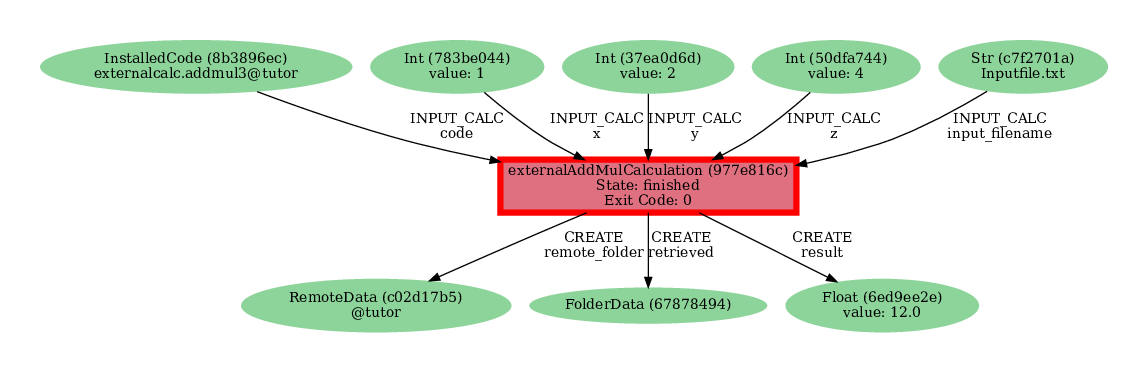

In [10]:
import subprocess
cmd = "verdi node graph generate {}".format(calcjob.pk)
subprocess.call(cmd,shell=True)

from wand.image import Image as WImage
WImage(filename="{}.dot.pdf".format(calcjob.pk))

command lineからは以下で入力ファイルが得られる。

In [11]:
! verdi calcjob inputls $calcjob.pk

.aiida
Inputfile.txt
_aiidasubmit.sh


## ファイル名の取得
### verdi経由

In [12]:
def read_calcjob_file_verdi(action, calcjob, path=None):
    pk = calcjob.pk
    if action in ["inputls", "outputls"]:
        cmd = "verdi calcjob {} {}".format(action, pk)
    elif action in ["inputcat", "outputcat"] and path is not None:
        cmd = "verdi calcjob {} {} {}".format(action, pk, path)
    else:
        raise TypeError
    proc = subprocess.run(cmd, shell=True, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    # return default
    print(cmd)

    return proc.stdout.decode("utf8"), proc.stderr.decode("utf8")

In [13]:
stdout, stderr = read_calcjob_file_verdi("inputls",calcjob)
print(stdout.split("\n"))

stdout, stderr = read_calcjob_file_verdi("outputls",calcjob)
print(stdout.split("\n"))

verdi calcjob inputls 10717
['.aiida', 'Inputfile.txt', '_aiidasubmit.sh', '']
verdi calcjob outputls 10717
['Outputfile.txt', '_scheduler-stderr.txt', '_scheduler-stdout.txt', 'aiida.out', '']


### 直接取得

In [14]:
def read_calcjob_file_directly(action, calcjob):
    if action == "inputls":
        return calcjob.list_objects()
    elif action == "outputls":
        return calcjob.outputs.retrieved.list_objects()

In [15]:
for entry in read_calcjob_file_directly("inputls",calcjob):
    print(entry.file_type, ";",entry.name)
for entry in read_calcjob_file_directly("outputls",calcjob):
    print(entry.file_type, ":", entry.name)

FileType.DIRECTORY ; .aiida
FileType.FILE ; Inputfile.txt
FileType.FILE ; _aiidasubmit.sh
FileType.FILE : Outputfile.txt
FileType.FILE : _scheduler-stderr.txt
FileType.FILE : _scheduler-stdout.txt
FileType.FILE : aiida.out


/tmp/ipykernel_15457/3527125437.py:3: AiidaDeprecationWarning: `CalcJobNode.list_objects` is deprecated, use `CalcJobNode.base.repository.list_objects` instead. (this will be removed in v3)
  return calcjob.list_objects()


コメント：普通は取得するファイル名はわかっている。

## ファイルの中身の取得
calcjobからファイルの中身を得る。

### verdi経由

In [16]:
def copy_calcjob_file(action, calcjob, path, outputdir):
    pk = calcjob.pk
    if action in ["inputls", "outputls"]:
        cmd = "verdi calcjob {} {}".format(action, pk)
    elif action in ["inputcat", "outputcat"] and path is not None:
        cmd = "verdi calcjob {} {} {}".format(action, pk, path)
    else:
        raise TypeError
    proc = subprocess.run(cmd, shell=True, stdout = subprocess.PIPE, stderr = subprocess.PIPE)
    # return default
    print(cmd)

    ret = 1
    if proc.returncode==0:
        outputfile = os.path.join(outputdir,path)
        with open(outputfile,"wb") as f:
            f.write(proc.stdout)
        ret = 0
    else:
        print(proc.stderr.decode("utf8"))
    return ret


In [17]:
def copy_input_and_output_files_verdi(calcjob, inputfilelist, 
                                          outputfilelist, outputdir, debugprint=False):
    if not os.path.isdir(outputdir):
        os.mkdir(outputdir)
        
    # input side
    for filename in inputfilelist:
        if debugprint:
            print(filename)
        ret  = copy_calcjob_file("inputcat",calcjob,filename, outputdir)
        print(ret,"for",filename)
        if ret !=0:
            raise FileNotFoundError

    # output side
    for filename in outputfilelist:
        if debugprint:
            print(filename)
        ret  = copy_calcjob_file("outputcat",calcjob,filename, outputdir)
        print(ret,"for", filename)
        if ret !=0:
            raise FileNotFoundError
            
    return 0
            
inputfilelist =  ["Inputfile.txt","_aiidasubmit.sh"]
outputfilelist = ["Outputfile.txt","aiida.out"]
outputdir = "ExecutedFile_verdi.{}".format(calcjob.pk)

copy_input_and_output_files_verdi(calcjob, inputfilelist, outputfilelist, outputdir)

verdi calcjob inputcat 10717 Inputfile.txt
0 for Inputfile.txt
verdi calcjob inputcat 10717 _aiidasubmit.sh
0 for _aiidasubmit.sh
verdi calcjob outputcat 10717 Outputfile.txt
0 for Outputfile.txt
verdi calcjob outputcat 10717 aiida.out
0 for aiida.out


0

In [18]:
# コピーされたファイルの確認
!ls $outputdir

Inputfile.txt  Outputfile.txt  _aiidasubmit.sh	aiida.out


verdi経由だとかなり鈍いので、次に、直接ファイルを取得する。

## 直接取得


### input側のファイルの取得

In [25]:
from shutil import copyfileobj

path = "Inputfile.txt"
with calcjob.base.repository.open(path, mode='rb') as fhandle:
    #copyfileobj(fhandle, sys.stdout)
    lines =fhandle.read().decode()
    print(lines)

1
2
4


### output側のファイルの取得

In [27]:
path = "Outputfile.txt"
retrieved = calcjob.outputs.retrieved
with retrieved.open(path, mode='rb') as fhandle:
    #copyfileobj(fhandle, sys.stdout)
    lines =fhandle.read().decode()
    print(lines)

12.0


### 両者をまとめる。

In [29]:
def copy_input_and_output_files_directly(calcjob, inputfilelist, 
                                         outputfilelist, outputdir, debugprint=False):

    if not os.path.isdir(outputdir):
        os.mkdir(outputdir)

    # input side
    for filename in inputfilelist:
        outputfilename = os.path.join(outputdir, filename)
        print(outputfilename)
        with open(outputfilename,"wb") as fout: #don't change the order of opening files.
            with calcjob.base.repository.open(filename, mode='rb') as fhandle:
                copyfileobj(fhandle, fout)

    # output side
    try:
        retrieved = calcjob.outputs.retrieved
    except AttributeError:
        print("No 'retrieved' node found. Have the calcjob files already been retrieved?")
        return 1
        
    for filename in outputfilelist:
        outputfilename = os.path.join(outputdir, filename)
        if debugprint:
            print(outputfilename)
        with open(outputfilename,"wb") as fout: #don't change the order of opening files.
            with retrieved.open(filename, mode='rb') as fhandle:
                copyfileobj(fhandle, fout)
    return 0

inputfilelist =  ["Inputfile.txt","_aiidasubmit.sh"]
outputfilelist = ["Outputfile.txt","aiida.out"]
outputdir = "ExecutedFile_direct.{}".format(calcjob.pk)
print(outputdir)
copy_input_and_output_files_directly(calcjob, inputfilelist, outputfilelist, outputdir)

ExecutedFile_direct.10717
ExecutedFile_direct.10717/Inputfile.txt
ExecutedFile_direct.10717/_aiidasubmit.sh


0

In [30]:
# コピーされたファイルの確認
!ls $outputdir

Inputfile.txt  Outputfile.txt  _aiidasubmit.sh	aiida.out


## クラス化

In [33]:
class CopyInputOutputFiles:
    def __init__(self, inputfilelist, outputfilelist, method="direct"):
        self.inputfilelist = inputfilelist
        self.outputfilelist = outputfilelist    
        self.method = method
        
    def mkdir(self, outputdir):
        if not os.path.isdir(outputdir):
            os.mkdir(outputdir)     

    def copy(self, calcjob,  outputdir, debugprint=False):
        if self.method == "direct":
            return self.copy_input_and_output_files_directly(calcjob,  outputdir, debugprint=False)
        elif self.method == "verdi":
            return self.copy_input_and_output_files_verdi(calcjob,  outputdir, debugprint=False)\
            
    def copy_input_and_output_files_directly(self, calcjob,  outputdir, debugprint=False):

        self.mkdir(outputdir)
        
        inputfilelist = self.inputfilelist
        outputfilelist = self.outputfilelist
        
        # input side
        for filename in inputfilelist:
            outputfilename = os.path.join(outputdir, filename)
            if debugprint:
                print(outputfilename)
            with open(outputfilename,"wb") as fout: #don't change the order of opening files.
                with calcjob.base.repository.open(filename, mode='rb') as fhandle:
                    copyfileobj(fhandle, fout)

        # output side
        try:
            retrieved = calcjob.outputs.retrieved
        except AttributeError:
            print("No 'retrieved' node found. Have the calcjob files already been retrieved?")
            return 1

        for filename in outputfilelist:
            outputfilename = os.path.join(outputdir, filename)
            if debugprint:
                print(outputfilename)
            with open(outputfilename,"wb") as fout: #don't change the order of opening files.
                with retrieved.open(filename, mode='rb') as fhandle:
                    copyfileobj(fhandle, fout)
        return 0
    
    def copy_input_and_output_files_verdi(self, calcjob, outputdir, debugprint=False):
        self.mkdir(outputdir)

        inputfilelist = self.inputfilelist
        outputfilelist = self.outputfilelist
        
        pk = calcjob.pk
        
        # input side
        for filename in inputfilelist:
            if debugprint:
                print(filename)
            ret  = copy_calcjob_file("inputcat",calcjob,filename, outputdir)
            if debugprint:
                print(ret,"for",filename)
            if ret !=0:
                raise FileNotFoundError

        # output side
        for filename in outputfilelist:
            if debugprint:
                print(filename)
            ret  = copy_calcjob_file("outputcat",calcjob,filename, outputdir)
            if debugprint:
                print(ret,"for", filename)
            if ret !=0:
                raise FileNotFoundError

        return 0

In [34]:
inputfilelist =  ["Inputfile.txt","_aiidasubmit.sh"]
outputfilelist = ["Outputfile.txt","aiida.out"]
outputdir = "ExecutedFile_classdirect.{}".format(calcjob.pk)
print(outputdir)
nodecopy = CopyInputOutputFiles(inputfilelist, outputfilelist)
nodecopy.copy(calcjob,outputdir)

ExecutedFile_classdirect.10717


0

In [35]:
! ls $outputdir

Inputfile.txt  Outputfile.txt  _aiidasubmit.sh	aiida.out


In [36]:
! cat $outputdir/Outputfile.txt

12.0

In [37]:
inputfilelist =  ["Inputfile.txt","_aiidasubmit.sh"]
outputfilelist = ["Outputfile.txt","aiida.out"]
outputdir = "ExecutedFile_classverdi.{}".format(calcjob.pk)
print(outputdir)
nodecopy = CopyInputOutputFiles(inputfilelist, outputfilelist, method="direct")
nodecopy.copy(calcjob,outputdir)

ExecutedFile_classverdi.10717


0

In [38]:
! ls $outputdir

Inputfile.txt  Outputfile.txt  _aiidasubmit.sh	aiida.out


In [39]:
! cat $outputdir/Outputfile.txt

12.0